In [168]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import os 
from datetime import datetime

In [169]:
# Earth's radius
EARTH_RADIUS_KM = 6371
# Centimeters to kilometers
CM_TO_KM_RATIO = 1e-5
# Here, input the file path to the base data directory
BASE_DIR = 'D:\Groundwater Vulnerability Mapping\data'
# Figure size
FIG_SIZE = (10, 10)

In [170]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

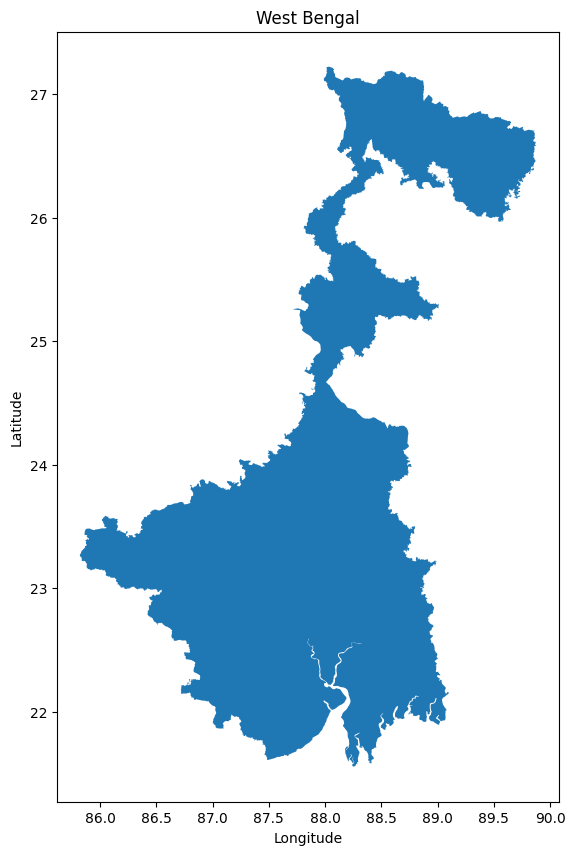

In [171]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


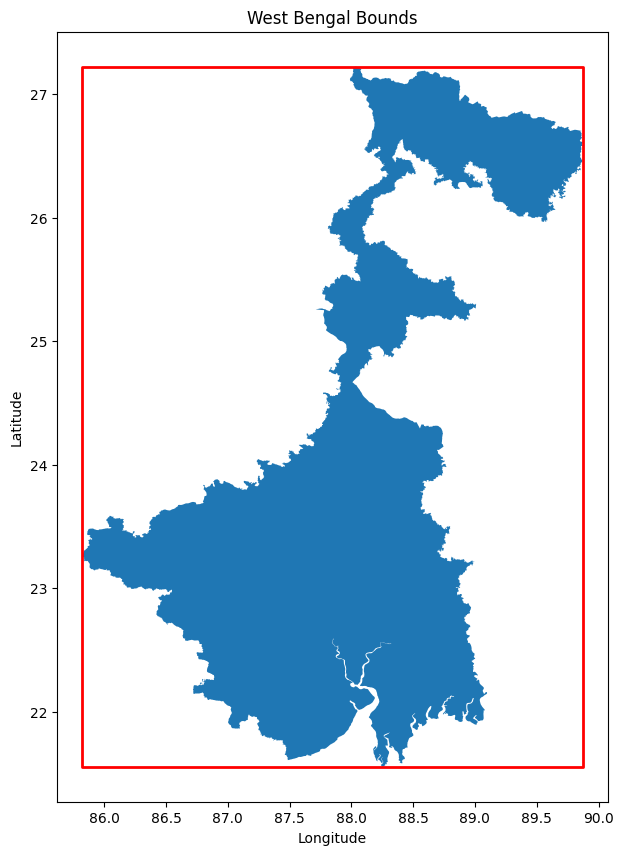

In [172]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [173]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, r"RAW Data\GRACE\GRCTellus.JPL.200204_202505.GLO.RL06.3M.MSCNv04CRI.nc"))

# print out grace data. Our varibale of interest (lwe_thickness) is measured in centimeters 
grace

<xarray.Dataset> Size: 2GB
Dimensions:        (lon: 720, lat: 360, time: 245, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-05-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 508MB ...
    uncertainty    (time, lat, lon) float64 508MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 508MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.3Mv04 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2025-07-09T14:07:30Z

In [174]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [175]:
# Subset GRACE data to WB region BEFORE converting to DataFrame
grace = grace.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)

In [176]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
0,86.25,21.75,2002-04-17 12:00:00,-27.015066,23.527598,0.921817
735,86.25,23.25,2002-04-17 12:00:00,-12.003431,22.887817,0.967227
1225,86.25,24.25,2002-04-17 12:00:00,-12.003431,22.887817,1.001268
16660,89.25,22.75,2002-04-17 12:00:00,-13.789784,22.970621,0.860325
8820,87.75,23.25,2002-04-17 12:00:00,-12.003431,22.887817,1.054784
...,...,...,...,...,...,...
14944,88.75,24.25,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15189,88.75,24.75,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15434,88.75,25.25,2025-05-16 12:00:00,-30.284789,14.307988,1.027741
13474,88.25,26.75,2025-05-16 12:00:00,-69.313839,10.175189,0.930138


In [177]:
# Compute surface area for pixel with dimensions n x n degree. Note the area of a pixel changes with respect to latitude!
degree_measure = 0.5
grace_df['surface_area_km2'] = EARTH_RADIUS_KM * np.radians(degree_measure) * EARTH_RADIUS_KM * np.radians(degree_measure) * np.cos(np.radians(grace_df['lat']))

# Convert units from cm to km^3
grace_df["lwe_thickness_km3"] = grace_df["lwe_thickness_cm"]  * CM_TO_KM_RATIO * grace_df['surface_area_km2'] * grace_df['scale_factor']
grace_df['uncertainty_km3'] = grace_df["uncertainty_cm"] * CM_TO_KM_RATIO * grace_df['surface_area_km2']

In [178]:
import xarray as xr

# Use raw string to handle Windows backslashes
ds = xr.open_dataset(
    r"D:\Groundwater Vulnerability Mapping\data\RAW Data\terraclimate\agg_terraclimate_soil_1958_CurrentYear_GLOBE.nc",
    engine="netcdf4"  # Force the engine
)

print(ds)

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 804, lat: 757, lon: 744)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB 38.98 38.94 38.9 38.85 ... 7.563 7.521 7.479
  * lon      (lon) float64 6kB 67.02 67.06 67.1 67.15 ... 97.85 97.9 97.94 97.98
Data variables:
    soil     (time, lat, lon) float64 4GB ...
Attributes: (12/50)
    method:                          These layers from TerraClimate were deri...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:        

In [179]:
import xarray as xr

# Open your TerraClimate soil moisture dataset
soil_dataset = xr.open_dataset(r'D:\Groundwater Vulnerability Mapping\data\RAW Data\terraclimate\agg_terraclimate_soil_1958_CurrentYear_GLOBE.nc')

# Print the dataset structure to see the variables, dimensions, and coordinates
print(soil_dataset)


# Open your TerraClimate snow water equivalent dataset
swe_dataset = xr.open_dataset(r'D:\Groundwater Vulnerability Mapping\data\RAW Data\terraclimate\agg_terraclimate_swe_1958_CurrentYear_GLOBE.nc')

# Print the dataset structure
print(swe_dataset)


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 804, lat: 757, lon: 744)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB 38.98 38.94 38.9 38.85 ... 7.563 7.521 7.479
  * lon      (lon) float64 6kB 67.02 67.06 67.1 67.15 ... 97.85 97.9 97.94 97.98
Data variables:
    soil     (time, lat, lon) float64 4GB ...
Attributes: (12/50)
    method:                          These layers from TerraClimate were deri...
    title:                           TerraClimate: monthly climate and climat...
    summary:                         This archive contains a dataset of high-...
    keywords:                        WORLDCLIM,global,monthly, temperature,pr...
    id:                              Blank
    naming_authority:                edu.uidaho.nkn
    ...                              ...
    geospatial_vertical_positive:    Up
    references:                      Abatzoglou, J.T., S.Z. Dobrowski, S.A. P...
    source:        

In [180]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray # For the .rio accessor

# --- Step 1: Define the rectangular bounding box for your basin ---
lon_min = 85.81
lon_max = 89.88
lat_min = 21.55
lat_max = 27.221

# --- Step 2: Create the 'soil_subset' and 'swe_subset' variables ---
# This was the missing step. We filter the full datasets to the bounding box.
print("Filtering data to the rectangular bounding box...")
soil_subset = soil_dataset.sel(lon=slice(lon_min, lon_max), lat=slice(lat_max, lat_min))
swe_subset = swe_dataset.sel(lon=slice(lon_min, lon_max), lat=slice(lat_max, lat_min))
print("Initial filtering complete.")


# --- Step 3: Load your basin's shapefile ---
# Using a raw string r'...' is safer for Windows paths
shapefile_path = r'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'
basin_shape = gpd.read_file(shapefile_path)

# --- Step 4: Precisely clip the data to the basin shapefile ---
print("\nClipping the data to the precise basin shapefile...")
soil_clipped = soil_subset.rio.write_crs("epsg:4326").rio.clip(basin_shape.geometry.values, basin_shape.crs, drop=False)
swe_clipped = swe_subset.rio.write_crs("epsg:4326").rio.clip(basin_shape.geometry.values, basin_shape.crs, drop=False)
print("Clipping complete.")

# --- Step 5: Pre-calculate the basin-wide anomalies from the CLIPPED data ---
print("\nPre-calculating basin-wide anomalies using clipped data...")

yearly_totals = []
for year in np.unique(soil_clipped['time.year']):
    # Convert the clipped data for one year to a DataFrame
    temp_df_soil = soil_clipped.sel(time=str(year)).to_dataframe().reset_index()
    temp_df_swe = swe_clipped.sel(time=str(year)).to_dataframe().reset_index()

    temp_df = pd.merge(temp_df_soil, temp_df_swe, on=['time', 'lon', 'lat'])
    
    # The .dropna() step is important here to remove the NaN pixels from the calculation
    temp_df.dropna(subset=['soil', 'swe'], inplace=True)
    
    EARTH_RADIUS_KM = 6371
    MM_TO_KM_RATIO = 1e-6
    degree_measure = 1/24
    
    temp_df['surface_area_km2'] = (EARTH_RADIUS_KM * np.radians(degree_measure))**2 * np.cos(np.radians(temp_df['lat']))
    temp_df["soil_volume_km3"] = temp_df["soil"] * MM_TO_KM_RATIO * temp_df['surface_area_km2']
    temp_df["swe_volume_km3"] = temp_df["swe"] * MM_TO_KM_RATIO * temp_df['surface_area_km2']
    
    yearly_totals.append(temp_df.groupby('time')[['soil_volume_km3', 'swe_volume_km3']].sum())

basin_storage = pd.concat(yearly_totals).reset_index()

mean_soil_storage = basin_storage['soil_volume_km3'].mean()
basin_storage['soil_anomaly_km3'] = basin_storage['soil_volume_km3'] - mean_soil_storage
mean_swe_storage = basin_storage['swe_volume_km3'].mean()
basin_storage['swe_anomaly_km3'] = basin_storage['swe_volume_km3'] - mean_swe_storage
print("Basin-wide anomalies calculated successfully.")

# --- Step 6: Process the CLIPPED data in yearly chunks and merge with anomalies ---
print("\nProcessing final data in yearly chunks...")
all_yearly_results = []
anomaly_columns_to_merge = ['time', 'soil_anomaly_km3', 'swe_anomaly_km3']

for year in np.unique(soil_clipped['time.year']):
    print(f"  - Processing and merging year: {year}")
    
    yearly_soil_df = soil_clipped.sel(time=str(year)).to_dataframe().reset_index()
    yearly_swe_df = swe_clipped.sel(time=str(year)).to_dataframe().reset_index()
    
    terraclimate_df = pd.merge(yearly_soil_df, yearly_swe_df, on=['time', 'lon', 'lat'])
    
    # Drop the NaN rows here as well so the final file only contains pixels inside the basin
    terraclimate_df.dropna(subset=['soil', 'swe'], inplace=True)
    terraclimate_df = terraclimate_df.rename(columns={'soil': 'soil_mm', 'swe': 'swe_mm'})

    comprehensive_yearly_df = pd.merge(
        terraclimate_df, 
        basin_storage[anomaly_columns_to_merge], 
        on='time'
    )
    
    all_yearly_results.append(comprehensive_yearly_df)

# --- Step 7: Combine all yearly results into the final comprehensive DataFrame ---
print("\nCombining all yearly chunks into the final comprehensive DataFrame...")
final_comprehensive_data = pd.concat(all_yearly_results, ignore_index=True)

# --- Step 8: Save the final, comprehensive file ---
output_filename_comprehensive = 'terraclimate_final_clipped_data.csv'
final_comprehensive_data.to_csv(output_filename_comprehensive, index=False) 

print(f"\n✅ All done! The comprehensive and precisely clipped data has been saved to '{output_filename_comprehensive}'")
print("\nHere is a preview of your final dataset:")
print(final_comprehensive_data.head())

Filtering data to the rectangular bounding box...
Initial filtering complete.

Clipping the data to the precise basin shapefile...
Clipping complete.

Pre-calculating basin-wide anomalies using clipped data...
Basin-wide anomalies calculated successfully.

Processing final data in yearly chunks...
  - Processing and merging year: 1958
  - Processing and merging year: 1959
  - Processing and merging year: 1960
  - Processing and merging year: 1961
  - Processing and merging year: 1962
  - Processing and merging year: 1963
  - Processing and merging year: 1964
  - Processing and merging year: 1965
  - Processing and merging year: 1966
  - Processing and merging year: 1967
  - Processing and merging year: 1968
  - Processing and merging year: 1969
  - Processing and merging year: 1970
  - Processing and merging year: 1971
  - Processing and merging year: 1972
  - Processing and merging year: 1973
  - Processing and merging year: 1974
  - Processing and merging year: 1975
  - Processing an

In [181]:
import pandas as pd

# Load the final CSV file you created in the last step
filename = 'terraclimate_final_clipped_data.csv'
final_data = pd.read_csv(filename)

# --- 1. Get the basic information: rows, columns, and data types ---
print("--- Data Summary ---")
final_data.info()
print("-" * 50)


# --- 2. See the first 5 rows to understand the structure ---
print("\n--- First 5 Rows ---")
print(final_data.head())
print("-" * 50)


# --- 3. See the last 5 rows to see the end of the time series ---
print("\n--- Last 5 Rows ---")
print(final_data.tail())
print("-" * 50)

--- Data Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3444336 entries, 0 to 3444335
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   lat               float64
 2   lon               float64
 3   crs_x             int64  
 4   soil_mm           float64
 5   crs_y             int64  
 6   swe_mm            float64
 7   soil_anomaly_km3  float64
 8   swe_anomaly_km3   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 236.5+ MB
--------------------------------------------------

--- First 5 Rows ---
         time        lat        lon  crs_x  soil_mm  crs_y  swe_mm  \
0  1958-01-01  27.187500  88.020833      0     76.4      0     0.0   
1  1958-01-01  27.187500  88.062500      0     74.8      0     0.0   
2  1958-01-01  27.145833  88.020833      0     77.9      0     0.0   
3  1958-01-01  27.145833  88.062500      0     75.0      0     0.0   
4  1958-01-01  27.145833  88.520833    

In [182]:
# --- OPTIONAL: Clean up the DataFrame ---

# Drop the unnecessary columns
final_data = final_data.drop(columns=['crs_x', 'crs_y'])

# Convert the 'time' column from a string to a datetime object
final_data['time'] = pd.to_datetime(final_data['time'])

print("--- Cleaned Data Summary ---")
final_data.info()
print("\n--- First 5 Rows of Cleaned Data ---")
print(final_data.head())


--- Cleaned Data Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3444336 entries, 0 to 3444335
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   time              datetime64[ns]
 1   lat               float64       
 2   lon               float64       
 3   soil_mm           float64       
 4   swe_mm            float64       
 5   soil_anomaly_km3  float64       
 6   swe_anomaly_km3   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 183.9 MB

--- First 5 Rows of Cleaned Data ---
        time        lat        lon  soil_mm  swe_mm  soil_anomaly_km3  \
0 1958-01-01  27.187500  88.020833     76.4     0.0         -2.022786   
1 1958-01-01  27.187500  88.062500     74.8     0.0         -2.022786   
2 1958-01-01  27.145833  88.020833     77.9     0.0         -2.022786   
3 1958-01-01  27.145833  88.062500     75.0     0.0         -2.022786   
4 1958-01-01  27.145833  88.520833     53.3     0.0  

In [183]:
import geopandas as gpd

# --- Step 1: Make sure you have your basin shapefile loaded ---
shapefile_path = 'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'
basin_shapefile = gpd.read_file(shapefile_path)


# --- Step 2: Convert your grace_df into a GeoDataFrame ---
# This is the first part of the code you shared
grace_gdf = gpd.GeoDataFrame(grace_df,
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat']))

# --- Step 3: Ensure the Coordinate Reference Systems match ---
basin_shapefile = basin_shapefile.to_crs('epsg:4326')


# --- Step 4: Perform the spatial join (the "clip") ---
# This is the core of the notebook's method
grace_clipped_df = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")


# --- Step 5: Clean up the final DataFrame ---
# The result will have extra columns from the shapefile; this selects only the original GRACE columns
final_grace_columns = ['lat', 'lon', 'time', 'lwe_thickness_cm', 'uncertainty_cm', 
                       'scale_factor', 'surface_area_km2', 'lwe_thickness_km3', 'uncertainty_km3']
grace_final_df = grace_clipped_df[final_grace_columns]

grace_output_filename = 'grace_processed_clipped.csv'
grace_final_df.to_csv(grace_output_filename, index=False)

print(f"\n✅ SUCCESS: The missing file '{grace_output_filename}' has now been created.")
print("You can now re-run your final merge script.")

print("GRACE data has been successfully clipped to the basin.")
print("\nPreview of the final, clipped GRACE data:")
print(grace_final_df.head())


✅ SUCCESS: The missing file 'grace_processed_clipped.csv' has now been created.
You can now re-run your final merge script.
GRACE data has been successfully clipped to the basin.

Preview of the final, clipped GRACE data:
         lat    lon                time  lwe_thickness_cm  uncertainty_cm  \
735    23.25  86.25 2002-04-17 12:00:00        -12.003431       22.887817   
8820   23.25  87.75 2002-04-17 12:00:00        -12.003431       22.887817   
9065   23.75  87.75 2002-04-17 12:00:00        -12.003431       22.887817   
9310   24.25  87.75 2002-04-17 12:00:00        -12.003431       22.887817   
18620  26.75  89.25 2002-04-17 12:00:00         -4.542763       16.118506   

       scale_factor  surface_area_km2  lwe_thickness_km3  uncertainty_km3  
735        0.967227       2840.055230          -0.329731         0.650027  
8820       1.054784       2840.055230          -0.359580         0.650027  
9065       1.054784       2829.299110          -0.358218         0.647565  
9310      

In [184]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
import dask # Dask is used by xarray in the background

# --- Step 1: Open the datasets using Dask chunks ---
print("Opening datasets using Dask for memory-efficient processing...")
soil_dataset = xr.open_dataset(r'D:\Groundwater Vulnerability Mapping\data\RAW Data\terraclimate\agg_terraclimate_soil_1958_CurrentYear_GLOBE.nc', chunks={'time': 12})
swe_dataset = xr.open_dataset(r'D:\Groundwater Vulnerability Mapping\data\RAW Data\terraclimate\agg_terraclimate_swe_1958_CurrentYear_GLOBE.nc', chunks={'time': 12})

# --- Step 2: Define the coarsening factor and downsample (lazy operation) ---
coarsening_factor = 12
print(f"Defining the downsampling operation (factor of {coarsening_factor})...")
coarsened_soil_ds = soil_dataset.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()
coarsened_swe_ds = swe_dataset.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()
print("Downsampling operation defined.")

# --- Step 3: Load shapefile and define the clipping operation (lazy operation) ---
print("\nDefining the clipping operation...")
# IMPORTANT: Update this path to your actual shapefile!
shapefile_path = 'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp' 
basin_shape = gpd.read_file(shapefile_path)

soil_clipped = coarsened_soil_ds.rio.write_crs("epsg:4326").rio.clip(basin_shape.geometry.values, basin_shape.crs, drop=False)
swe_clipped = coarsened_swe_ds.rio.write_crs("epsg:4326").rio.clip(basin_shape.geometry.values, basin_shape.crs, drop=False)
print("Clipping operation defined.")

# --- Step 4: Execute the Dask graph and convert to DataFrame ---
# THE FIX IS HERE: Call .compute() BEFORE .to_dataframe()
print("\nExecuting all operations and converting to DataFrame (this may take some time)...")
soil_df = soil_clipped.compute().to_dataframe().reset_index()
swe_df = swe_clipped.compute().to_dataframe().reset_index()
print("Computation and conversion complete.")

# --- Step 5: Proceed with pandas as normal ---
# The rest of the operations are on smaller DataFrames and are safe.
print("\nCalculating volumes and anomalies...")

# Merge the two DataFrames
terraclimate_df = pd.merge(soil_df, swe_df, on=['time', 'lon', 'lat'])

# Drop pixels outside the basin
terraclimate_df.dropna(subset=['soil', 'swe'], inplace=True)
terraclimate_df = terraclimate_df.rename(columns={'soil': 'soil_mm', 'swe': 'swe_mm'})

# Calculate Volume
EARTH_RADIUS_KM = 6371
MM_TO_KM_RATIO = 1e-6
degree_measure = 0.5 # Resolution of the new coarse grid

terraclimate_df['surface_area_km2'] = (EARTH_RADIUS_KM * np.radians(degree_measure))**2 * np.cos(np.radians(terraclimate_df['lat']))
terraclimate_df["soil_volume_km3"] = terraclimate_df["soil_mm"] * MM_TO_KM_RATIO * terraclimate_df['surface_area_km2']
terraclimate_df["swe_volume_km3"] = terraclimate_df["swe_mm"] * MM_TO_KM_RATIO * terraclimate_df['surface_area_km2']

# Calculate Basin-Wide Anomaly
basin_storage = terraclimate_df.groupby('time')[['soil_volume_km3', 'swe_volume_km3']].sum().reset_index()
mean_soil_storage = basin_storage['soil_volume_km3'].mean()
basin_storage['soil_anomaly_km3'] = basin_storage['soil_volume_km3'] - mean_soil_storage
mean_swe_storage = basin_storage['swe_volume_km3'].mean()
basin_storage['swe_anomaly_km3'] = basin_storage['swe_volume_km3'] - mean_swe_storage

# Merge anomalies back and save the final file
anomaly_columns_to_merge = ['time', 'soil_anomaly_km3', 'swe_anomaly_km3']
final_data = pd.merge(terraclimate_df, basin_storage[anomaly_columns_to_merge], on='time')

# Clean up and select final columns
final_columns = ['time', 'lat', 'lon', 'soil_volume_km3', 'swe_volume_km3', 'soil_anomaly_km3', 'swe_anomaly_km3']
final_data = final_data[final_columns]

output_filename = 'terraclimate_downsampled_final_data.csv'
final_data.to_csv(output_filename, index=False)

print(f"\n✅ All done! Your downsampled and processed data has been saved to '{output_filename}'")
print("\nHere is a preview of your final dataset:")
print(final_data.head())

Opening datasets using Dask for memory-efficient processing...
Defining the downsampling operation (factor of 12)...
Downsampling operation defined.

Defining the clipping operation...
Clipping operation defined.

Executing all operations and converting to DataFrame (this may take some time)...
Computation and conversion complete.

Calculating volumes and anomalies...

✅ All done! Your downsampled and processed data has been saved to 'terraclimate_downsampled_final_data.csv'

Here is a preview of your final dataset:
        time    lat    lon  soil_volume_km3  swe_volume_km3  soil_anomaly_km3  \
0 1958-01-01  26.75  88.25         0.195082             0.0         -1.981413   
1 1958-01-01  26.75  88.75         0.199100             0.0         -1.981413   
2 1958-01-01  26.75  89.25         0.229859             0.0         -1.981413   
3 1958-01-01  26.25  88.25         0.194373             0.0         -1.981413   
4 1958-01-01  26.25  89.25         0.224697             0.0         -1.98

In [185]:
import pandas as pd
import xarray as xr

# --- Step 1: Load your two processed datasets ---
print("Loading processed GRACE and TerraClimate data...")
grace_df = pd.read_csv('grace_processed_clipped.csv')
terraclimate_df = pd.read_csv('terraclimate_downsampled_final_data.csv')

# Convert time columns to datetime for proper alignment
grace_df['time'] = pd.to_datetime(grace_df['time'])
terraclimate_df['time'] = pd.to_datetime(terraclimate_df['time'])

# --- Step 2: Convert to xarray and align the grids ---
print("Aligning coordinate grids using 'nearest neighbor' method...")

# Set lat/lon/time as the index to create xarray Datasets
grace_xr = grace_df.set_index(['lat', 'lon', 'time']).to_xarray()
terraclimate_xr = terraclimate_df.set_index(['lat', 'lon', 'time']).to_xarray()

# Reindex the TerraClimate data to match the GRACE coordinates exactly
terraclimate_aligned = terraclimate_xr.reindex_like(grace_xr, method='nearest')

# --- Step 3: Convert back to DataFrames for the final merge ---
# Convert the aligned data back to a DataFrame
terraclimate_aligned_df = terraclimate_aligned.to_dataframe().reset_index()

# Now, we merge the original GRACE df with the ALIGNED TerraClimate df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    terraclimate_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)
print("Merge complete.")

# --- Step 4: Inspect and Save ---
print("\n--- Data Summary of Final Merged File ---")
final_merged_df.info()
print("\n--- Preview of Final Merged Data ---")
print(final_merged_df.head())

final_output_filename = 'grace_terraclimate_final_merged_data.csv'
final_merged_df.to_csv(final_output_filename, index=False)

print(f"\n✅ All done! Your final, correctly merged data has been saved to '{final_output_filename}'")

Loading processed GRACE and TerraClimate data...
Aligning coordinate grids using 'nearest neighbor' method...
Merging aligned datasets...
Merge complete.

--- Data Summary of Final Merged File ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7105 entries, 0 to 7104
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   lat                7105 non-null   float64       
 1   lon                7105 non-null   float64       
 2   time               7105 non-null   datetime64[ns]
 3   lwe_thickness_cm   7105 non-null   float64       
 4   uncertainty_cm     7105 non-null   float64       
 5   scale_factor       7105 non-null   float64       
 6   surface_area_km2   7105 non-null   float64       
 7   lwe_thickness_km3  7105 non-null   float64       
 8   uncertainty_km3    7105 non-null   float64       
 9   soil_volume_km3    7105 non-null   float64       
 10  swe_volume_km3     7105 non-nul